## COMP767: Assignment 2, Question 1(a)

**Comparing the performance of SARSA, expected SARSA and Q-learning on the Taxi domain from the Gym environment suite**

By Surya Penmetsa and Joshua Durso-Finley



## Importing libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gym
import random
random.seed(0)
np.random.seed(0)
import time

In [2]:
matplotlib.rcParams['figure.figsize'] = (18, 6)

## Creating Agent class

In [3]:
class Agent:
    # Setting things up
    def __init__(self, env, eps=0.2, gamma = 1):
        self.noStates = env.observation_space.n
        self.noActions = env.action_space.n
        self.Q = np.zeros((self.noStates, self.noActions))
        self.eps = eps
        self.gamma = gamma
        self.updates = 0
        
    def reset(self):
        self.Q = np.zeros((self.noStates, self.noActions))
    
    # Function to do eps-greedy exploration
    def chooseActionEps(self, presentState):
        if(np.random.rand(1)<self.eps): # Explore
            return np.random.randint(self.noActions)
        else: # Exploit
            return np.argmax(self.Q[presentState, :])
        
    # Function to exploit
    def chooseActionExploit(self, presentState):
        return np.argmax(self.Q[presentState, :])
        
    # Function to do softmax exploration
    def chooseActionSoftmax(self, presentState, temp=0.1):
        pi = np.exp(self.Q[presentState, :]/temp)/np.sum(np.exp(self.Q[presentState, :]/temp))
        V = np.cumsum(pi)
        c, = np.where(V-np.random.rand(1)>0)
#         a = np.argmax(np.random.multinomial(1, pi))
        return c[0]
        
    # Function for SARSA policy updates
    def updatePolicySARSA(self, S, A, R, S2, A2, alpha):
        self.updates = self.updates + 1
        self.Q[S,A] = self.Q[S,A] + alpha * (R + self.gamma * self.Q[S2, A2] - self.Q[S,A])
    
    # Function for Qlearning policy updates
    def updatePolicyQlearning(self, S, A, R, S2, A2, alpha):
        self.updates = self.updates + 1
        self.Q[S,A] = self.Q[S,A] + alpha * (R + self.gamma * np.max(self.Q[S2, :]) - self.Q[S,A])
        
    # Function for Expected SARSA policy updates
    def updatePolicyExpSARA(self, S, A, R, S2, A2, alpha):
        self.updates = self.updates + 1
        self.Q[S,A] = self.Q[S,A] + alpha * (R + self.gamma * np.mean(self.Q[S2, A2]) - self.Q[S,A])
        

## Function to run SARSA, Q-learning and Expected SARDA

In [4]:
def runAlgorithm(env, agent, alpha=0.9,temp=0.1, runs=10, segments=100, update='SARSA', debug=False):
    """
    Function to run SARSA, expected SARSA and Q-learning in the taxi environment.
    
    Inputs:
        runs -> total number of independent runs
        segments -> mentioned in question
        update -> one of SARSA, Qlearning, ExpSARSA
        
        
    Outputs:
        stepsInEpisode -> 2D matrix with steps per episode
        returnInEpisode -> 2D matrix with returns per episode
    """

    # Setting up variables
    totalEpisodes = segments * 11
    stepsInEpisode = np.zeros((runs, totalEpisodes))
    returnInEpisode = np.zeros((runs, totalEpisodes))
    
    # Loop for each independent run
    for run in range(0, runs):
        if(debug):
            print('Run: ', run)
            
        agent.reset()
        
        # Loop for each episode
        for episode in range(0, totalEpisodes):
            
            # Setting up environment
            S = env.reset()
            
            # Choosing Action
            if(episode%11 == 10): # Exploitation
                A = agent.chooseActionExploit(S)
            else: # Exploration
                A = agent.chooseActionSoftmax(S, temp=temp)

            # Loop for each timestep in the episode
            count = 0
            while True:
                # Stepping through environments and noting reward
                S2, R, done, info = env.step(A)
                returnInEpisode[run, episode] += R

                # Choosing Action
                if(episode%11 == 10):
                    A2 = agent.chooseActionExploit(S2)
                else:
                    A2 = agent.chooseActionSoftmax(S2, temp=temp)
                
                    # Policy update based on algorithm
                    if(update=='SARSA'):
                        agent.updatePolicySARSA(S, A, R, S2, A2, alpha=alpha)
                    elif(update=='Qlearning'):
                        agent.updatePolicyQlearning(S, A, R, S2, A2, alpha=alpha)
                    else:
                        agent.updatePolicyExpSARA(S, A, R, S2, A2, alpha=alpha)
                   
                # Updating variables
                S = S2
                A = A2
                
                count = count + 1
                # Checking for termination
                if(done == True):
                    break

            stepsInEpisode[run, episode] = count
            
    return stepsInEpisode, returnInEpisode

## Generating the u-shaped plots

In [5]:
def generateUplots(alpha_vec = [0.3, 0.8, 1], temp_vec = [0.1, 0.5, 1], update='SARSA'):
    # Setting up agent and environment
    env = gym.make('Taxi-v2')
    agent = Agent(env)
    
    # Loop to run through each possibility
    fig, axes = plt.subplots(1, 2)
    for temp in temp_vec:
        returnA = []; returnB = []
        for alpha in alpha_vec:
            start_time = time.time()
            print('Running for (alpha, temp) = ', alpha, temp)
            env = gym.make('Taxi-v2')
            agent = Agent(env)
            stepsInEpisode, returnInEpisode = runAlgorithm(env, agent, alpha=alpha, temp=temp, update=update)
            returnA.append(np.mean(returnInEpisode[:,-11:-1]))
            returnB.append(np.mean(returnInEpisode[:,-1]))
            print('Time to run: ', time.time()-start_time)

        axes[0].plot(alpha_vec, returnA, '.-', label='temp = '+str(temp))
        axes[1].plot(alpha_vec, returnB, '.-', label='temp = '+str(temp))

    axes[0].set_xlabel('alpha'), axes[0].set_ylabel('Return'), axes[0].legend(), axes[0].set_title('Requirement 1: '+update)
    axes[1].set_xlabel('alpha'), axes[1].set_ylabel('Return'), axes[1].legend(), axes[1].set_title('Requirement 2: '+update)
    plt.show()

### SARSA

Running for (alpha, temp) =  0.25 0.1
Time to run:  26.4413161277771
Running for (alpha, temp) =  0.5 0.1
Time to run:  21.389615297317505
Running for (alpha, temp) =  0.75 0.1
Time to run:  15.831517457962036
Running for (alpha, temp) =  0.25 1
Time to run:  36.92008996009827
Running for (alpha, temp) =  0.5 1
Time to run:  19.035533666610718
Running for (alpha, temp) =  0.75 1
Time to run:  15.594012022018433
Running for (alpha, temp) =  0.25 2
Time to run:  38.86337947845459
Running for (alpha, temp) =  0.5 2
Time to run:  24.169758081436157
Running for (alpha, temp) =  0.75 2
Time to run:  23.252537727355957


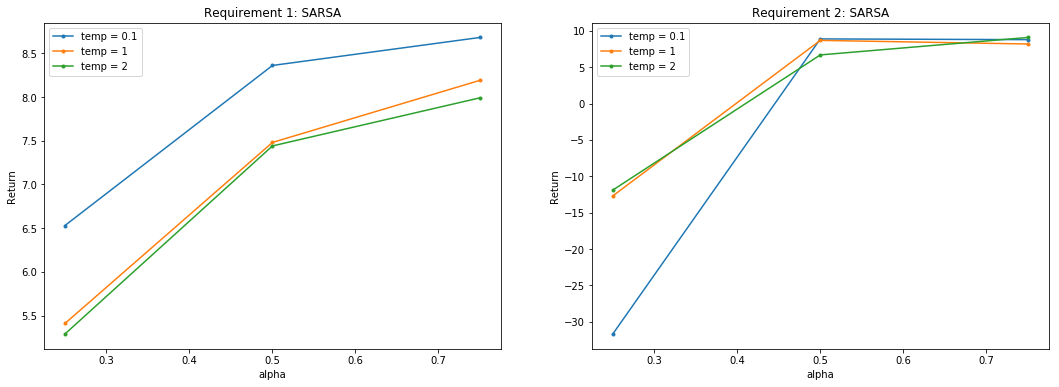

In [18]:
generateUplots(alpha_vec = [0.25, 0.5, 0.75], temp_vec = [0.1, 1, 2], update='SARSA')

### Qlearning

Running for (alpha, temp) =  0.25 0.1
Time to run:  28.680042028427124
Running for (alpha, temp) =  0.5 0.1
Time to run:  19.47732663154602
Running for (alpha, temp) =  0.75 0.1
Time to run:  16.66833519935608
Running for (alpha, temp) =  0.25 1
Time to run:  39.07711982727051
Running for (alpha, temp) =  0.5 1
Time to run:  24.223427772521973
Running for (alpha, temp) =  0.75 1
Time to run:  22.21774697303772
Running for (alpha, temp) =  0.25 2
Time to run:  41.245760679244995
Running for (alpha, temp) =  0.5 2
Time to run:  31.656180143356323
Running for (alpha, temp) =  0.75 2
Time to run:  22.976210355758667


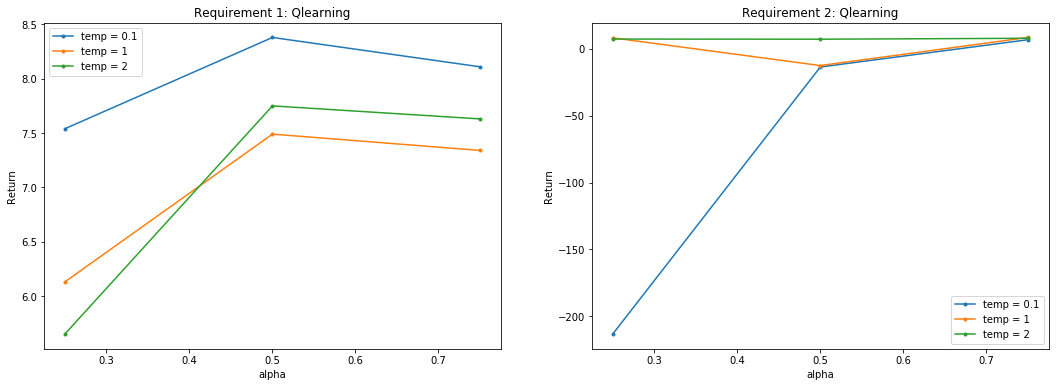

In [7]:
generateUplots(alpha_vec = [0.25, 0.5, 0.75], temp_vec = [0.1, 1, 2], update='Qlearning')

### Expected SARSA

Running for (alpha, temp) =  0.25 0.1
Time to run:  32.10515022277832
Running for (alpha, temp) =  0.5 0.1
Time to run:  25.398430347442627
Running for (alpha, temp) =  0.75 0.1
Time to run:  20.588545560836792
Running for (alpha, temp) =  0.25 1
Time to run:  47.917346477508545
Running for (alpha, temp) =  0.5 1
Time to run:  31.663718461990356
Running for (alpha, temp) =  0.75 1
Time to run:  22.23527765274048
Running for (alpha, temp) =  0.25 2
Time to run:  45.789071559906006
Running for (alpha, temp) =  0.5 2
Time to run:  30.799376726150513
Running for (alpha, temp) =  0.75 2
Time to run:  34.440213680267334


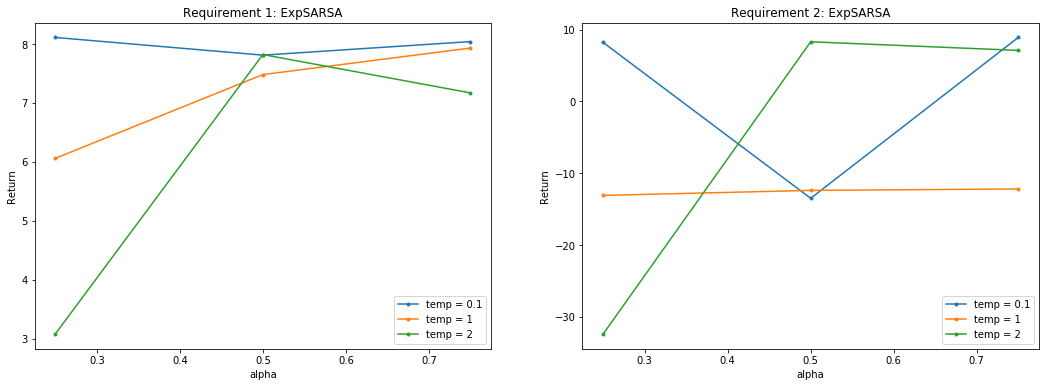

In [19]:
generateUplots(alpha_vec = [0.25, 0.5, 0.75], temp_vec = [0.1, 1, 2], update='ExpSARSA')

## Plotting the learning curves for optimal values

In [11]:
trainEpisodeIndex = np.arange(1100).reshape(100,11)
trainEpisodeIndex = trainEpisodeIndex[:,:10].flatten()

### Function to plot learning curves

In [23]:
def plotLearningCurves(bestAlpha=0.8, bestT=1, update='SARSA'):

    env = gym.make('Taxi-v2')
    agent = Agent(env)
    stepsInEpisode, returnInEpisode = runAlgorithm(env, agent, alpha=bestAlpha, temp=bestT, update=update)
    returnInEpisode = returnInEpisode[:, trainEpisodeIndex]
    mu = np.mean(returnInEpisode, axis=0)
    sigma = np.std(returnInEpisode, axis=0)
    plt.plot(range(1000), mu, 'k-', label='return')
    plt.fill_between(range(1000), mu-sigma, mu+sigma, facecolor='blue', label='deviation', alpha=0.5)
    plt.ylabel('average return'), plt.xlabel('training episode')
    plt.title('Requirement 3: ' + update + ', alpha = ' + str(bestAlpha) + ', temperature = ' + str(bestT))
    plt.legend(), plt.show()

** The values of alpha and temperature have been chosen by looking at the plots above. The average return in the training episodes is used to decide the optimal value. **

### Plots for SARSA, Qlearning and Expeceted SARSA

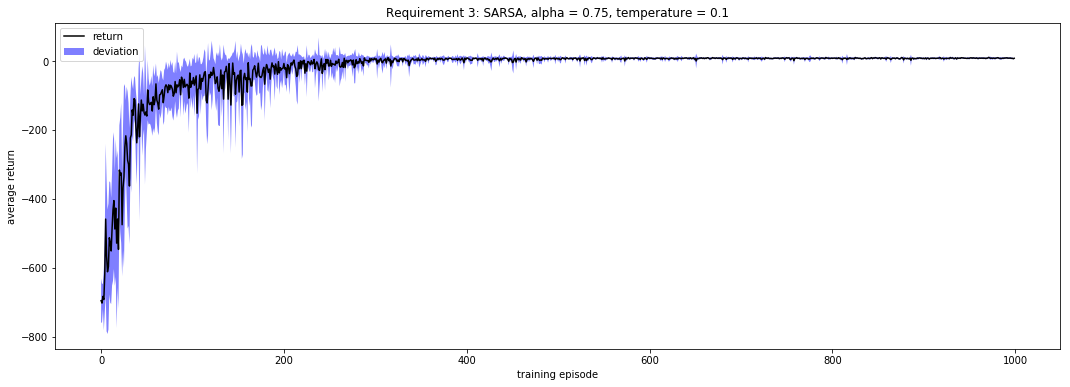

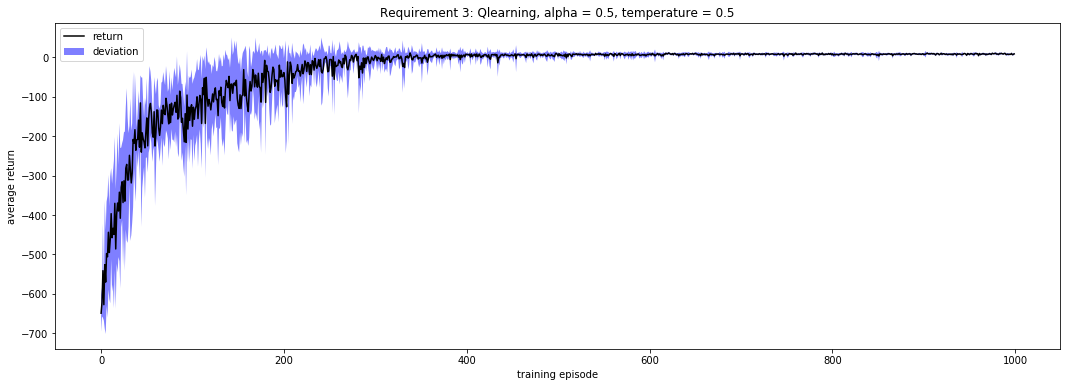

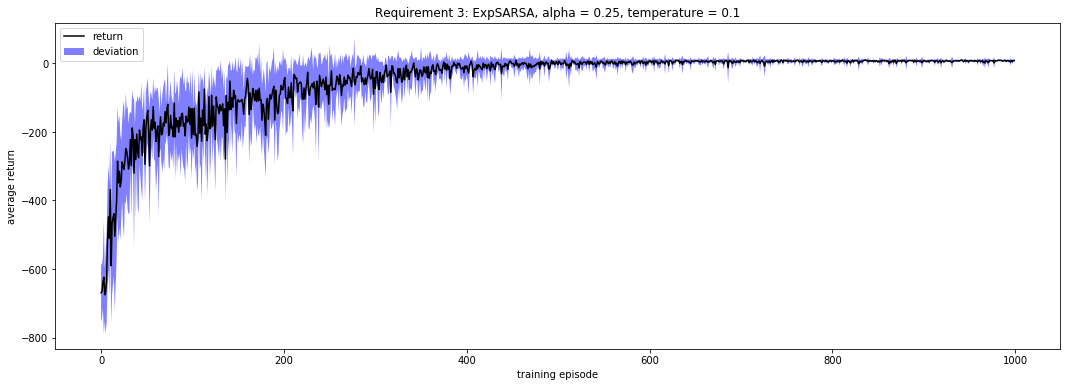

In [24]:
plotLearningCurves(bestAlpha=0.75, bestT=0.1, update='SARSA')
plotLearningCurves(bestAlpha=0.5, bestT=0.5, update='Qlearning')
plotLearningCurves(bestAlpha=0.25, bestT=0.1, update='ExpSARSA')

** The report for the code is uploaded in a seperate document.**